In [ ]:
!pip install pytorch_pretrained_bert --upgrade
!pip install utils --upgrade
!pip install urllib3 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 29.9 MB/s 
     |████████████████████████████████| 132 kB 69.3 MB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 9.2 MB 55.5 MB/s 
     |████████████████████████████████| 140 kB 68.7 MB/s 
     |████████████████████████████████| 127 kB 74.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uni

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
import pickle
from collections import Counter


class MosiVideoDataset(Dataset):
    def __init__(self, annotations_file):
        self.data = []

        data = pd.read_pickle(annotations_file)
        max_audio_length = 0

        for item in data:
            text_features = item[0]
            audio_features = item[1]
            video_features = item[2]
            sentiment = item[3]

            self.data.append((text_features, audio_features, video_features, sentiment))
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        elem = self.data[idx]
        #      text,    audio,   video,    sentiment
        return elem[0], elem[1], elem[2], elem[3]


train_dataset = MosiVideoDataset('/content/drive/MyDrive/ИТМО/НИР3/notebooks/mosi_train.pkl')
test_dataset = MosiVideoDataset('/content/drive/MyDrive/ИТМО/НИР3/notebooks/mosi_test.pkl')

In [ ]:
train_dataset[0]

In [ ]:
len(train_dataset)

1970

In [ ]:
import numpy as np

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report


def multi_metrics(preds, y):
    _, y_pred_tags = torch.max(preds, dim = 1)
    _, y_tags = torch.max(y, dim = 1)
    
    y_pred_tags = y_pred_tags.cpu().data
    y_tags = y_tags.cpu().data

    acc = accuracy_score(y_tags, y_pred_tags, normalize=True)
    prec = precision_score(y_tags, y_pred_tags, average='weighted')
    f1 = f1_score(y_tags, y_pred_tags, average='weighted')
    rec = recall_score(y_tags, y_pred_tags, average='weighted')
    report = classification_report(y_tags, y_pred_tags, output_dict=True)
    
    return acc, prec, f1, rec, report


def multi_metrics_for_valid(y_pred_tags, y_tags):
    acc = accuracy_score(y_tags, y_pred_tags, normalize=True)
    prec = precision_score(y_tags, y_pred_tags, average='weighted')
    f1 = f1_score(y_tags, y_pred_tags, average='weighted')
    rec = recall_score(y_tags, y_pred_tags, average='weighted')
    report = classification_report(y_tags, y_pred_tags, output_dict=True)
    
    return acc, prec, f1, rec, report

In [ ]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0.0
    y_preds_tags_array = []
    y_tags_array = []
    
    model.eval()
    
    with torch.no_grad():
    
        for idx, (video, audio, text, attr, labels) in enumerate(dataloader):
            # features = features.unsqueeze(1)
            
            video = video.to(device)
            text = text.to(device)
            audio = audio.to(device)
            attr = attr.to(device)
            labels = labels.to(device)
            
            predictions = model(text, audio, video, attention_mask=attr)[0]
            
            # loss = torch.nn.functional.cross_entropy(predictions, labels)

            _, y_pred_tags = torch.max(predictions, dim = 1)
            _, y_tags = torch.max(labels, dim = 1)
            y_pred_tags = y_pred_tags.cpu().data
            y_tags = y_tags.cpu().data
            y_preds_tags_array.extend(predictions)
            y_tags_array.extend(labels)

            torch.cuda.empty_cache()

    acc, prec, f1, rec, report = multi_metrics_for_valid(y_preds_tags_array, y_tags_array)
        
    return epoch_loss / len(dataloader), acc, prec, f1, rec, report

In [ ]:
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = []
    epoch_prec = []
    epoch_f1 = []
    epoch_rec = []
    report = {}
    
    model.train()
    
    for idx, (video, audio, text, attr, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        video = video.to(device)
        text = text.to(device)
        audio = audio.to(device)
        attr = attr.to(device)
        labels = labels.to(device) 
        
        loss = model(text, audio, video, attention_mask=attr, labels=labels)
        loss = loss.mean()
        loss.backward()

        # print(predictions, type(predictions))
        # print(labels, type(labels))
        # print(len(predictions), labels.shape)
        
        # print(predictions.shape, labels.shape)
        # loss = torch.nn.functional.cross_entropy(predictions, labels)
        # acc, prec, f1, rec, report = multi_metrics(predictions, labels)
        # loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # epoch_acc.append(acc)
        # epoch_prec.append(prec)
        # epoch_f1.append(f1)
        # epoch_rec.append(rec)

        torch.cuda.empty_cache()

    return epoch_loss / len(dataloader), epoch_acc, epoch_prec, epoch_f1, epoch_rec, report

In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 28.1 MB/s 
     |████████████████████████████████| 7.6 MB 50.9 MB/s 
     |████████████████████████████████| 163 kB 68.9 MB/s 
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

from string import punctuation 
import nltk
nltk.download('punkt')

punctuations = list(punctuation)
punkt = ['``','...',"''",'«','»','…','”','”','“','-','–','..']
punctuations.extend(punkt)


max_l = 25
video_lengths = []
group_size = 10
overlap = 5

BATCH_SIZE = 24
TEXT_MAX_LENGTH = 50


def collate_batch(batch):
    label_list, video_list = [], []
    text_list, att_masks = [], []
    audio_list = []

    for (_text_features, _audio_features, _video_features, _label) in batch:
        global max_l
        global video_lengths

        # label_map = [0.0] * 7
        # label_map[_label] = 1.0
        # label_list.append(label_map)

        label_list.append(_label)

        float_f = []

        video_lengths.append(len(_video_features))

        ind = 0
        while ind < max_l:
            group = []
            end_pos = ind + overlap

            for i in range(ind, end_pos):
                if i >= len(_video_features):
                    break
                f = _video_features[i]
                if f != []:
                    f = rgb2gray(f)
                else:
                    f = [[0 for col in range(64)] for row in range(64)]
                f = torch.FloatTensor(f)

                group.append(f)
            
            for i in range(len(group), group_size):
                group.append(torch.zeros(64, 64))

            group = torch.transpose(pad_sequence(group), 0, 1)
            float_f.append(group)
            ind += overlap
            
        try:
            X = torch.transpose(pad_sequence(float_f), 0, 1)
        except Exception:
            print(len(float_f), float_f[0].shape, float_f[1].shape)
            raise Exception

        # text = " ".join([word for word in tokenizer.tokenize(_text_features) if word not in stops and word.isalpha and word not in punctuations])
        pt = tokenizer(_text_features, padding="max_length", add_special_tokens=True, max_length=TEXT_MAX_LENGTH, return_tensors="pt")

        text_list.append(pt["input_ids"][0][:TEXT_MAX_LENGTH])
        att_masks.append(pt["attention_mask"][0][:TEXT_MAX_LENGTH])
        audio_list.append(_audio_features)
        video_list.append(X)

    # 3d
    video_features_tensor = torch.transpose(pad_sequence(video_list), 0, 1)
    
    audio_tensor = torch.FloatTensor(audio_list)
    audio_tensor = torch.unsqueeze(audio_tensor, 1)

    # print([t.shape for t in text_list])

    text_tensor = torch.stack(text_list)
    att_tensor = torch.stack(att_masks)

    label_tensor = torch.FloatTensor(label_list)

    # print(video_features_tensor.shape, audio_tensor.shape, text_tensor.shape)

    return video_features_tensor, audio_tensor, text_tensor, att_tensor, label_tensor


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
from pytorch_pretrained_bert.file_utils import cached_path
import copy
import json
import logging
import math
import os
import shutil
import torch.nn.functional as F
import tarfile
import tempfile
import sys
from io import open

import torch
from torch import nn
from torch.nn import CrossEntropyLoss

from utils import *

logger = logging.getLogger(__name__)

PRETRAINED_MODEL_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased.tar.gz",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased.tar.gz",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased.tar.gz",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz",
}

def bi_modal_attention(x, y):
    m1 = torch.matmul(x,y.transpose(-1, -2))
    n1 = nn.Softmax(dim=-1)(m1)
    o1 = torch.matmul(n1,y)
    a1 = torch.mul(o1, x)

    m2 = torch.matmul(y,x.transpose(-1, -2))
    n2 = nn.Softmax(dim=-1)(m2)
    o2 = torch.matmul(n2,x)
    a2 = torch.mul(o2, y)
    return a1,a2

def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}


class BertConfig(object):
    def __init__(self,
                 vocab_size_or_config_json_file,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 initializer_range=0.02):
        if isinstance(vocab_size_or_config_json_file, str) or (sys.version_info[0] == 2
                        and isinstance(vocab_size_or_config_json_file, unicode)):
            with open(vocab_size_or_config_json_file, "r", encoding='utf-8') as reader:
                json_config = json.loads(reader.read())
            for key, value in json_config.items():
                self.__dict__[key] = value
        elif isinstance(vocab_size_or_config_json_file, int):
            self.vocab_size = vocab_size_or_config_json_file
            self.hidden_size = hidden_size
            self.num_hidden_layers = num_hidden_layers
            self.num_attention_heads = num_attention_heads
            self.hidden_act = hidden_act
            self.intermediate_size = intermediate_size
            self.hidden_dropout_prob = hidden_dropout_prob
            self.attention_probs_dropout_prob = attention_probs_dropout_prob
            self.max_position_embeddings = max_position_embeddings
            self.type_vocab_size = type_vocab_size
            self.initializer_range = initializer_range
        else:
            raise ValueError("First argument must be either a vocabulary size (int)"
                             "or the path to a pretrained model config file (str)")

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BertConfig` from a Python dictionary of parameters."""
        config = BertConfig(vocab_size_or_config_json_file=-1)
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r", encoding='utf-8') as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

try:
    from apex.normalization.fused_layer_norm import FusedLayerNorm as BertLayerNorm
except ImportError:
    print("Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.")
    class BertLayerNorm(nn.Module):
        def __init__(self, hidden_size, eps=1e-12):
            """Construct a layernorm module in the TF style (epsilon inside the square root).
            """
            super(BertLayerNorm, self).__init__()
            self.weight = nn.Parameter(torch.ones(hidden_size))
            self.bias = nn.Parameter(torch.zeros(hidden_size))
            self.variance_epsilon = eps

        def forward(self, x):
            u = x.mean(-1, keepdim=True)
            s = (x - u).pow(2).mean(-1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.variance_epsilon)
            return self.weight * x + self.bias

class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids,token_type_ids=None):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        #在第一维增加一维，`input_ids`: a torch.LongTensor of shape [batch_size, sequence_length] with the word token indices in the vocabulary
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        #对应paper中segment embeddings 
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        
        embeddings = words_embeddings + position_embeddings + token_type_embeddings 
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


        
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states,audio_data, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states,input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states



class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor,audio_data,attention_mask):
        self_output = self.self(input_tensor,audio_data,attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)#过一层Multi-Head Attention 然后与input加和过一层Norm层
        self.intermediate = BertIntermediate(config)#过一层Linear然后过gelu激活函数
        self.output = BertOutput(config)#过一层Linear然后过dropout然后与input加和过norm

    def forward(self, hidden_states,all_audio_data,attention_mask):
        attention_output = self.attention(hidden_states,all_audio_data,attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

        
class BertFinetun(nn.Module):
    def __init__(self, config):
        super(BertFinetun, self).__init__()
        self.proj_t = nn.Conv1d(768,30, kernel_size=1, padding=0, bias=False)
        self.proj_a = nn.Conv1d(5,30, kernel_size=1, padding=0, bias=False)

        ch1, ch2 = 32, 48
        k1, k2 = (5, 5, 5), (2, 3, 3)  # 3d kernel size
        s1, s2 = (2, 2, 2), (2, 2, 2)  # 3d strides
        pd1, pd2 = (1, 1, 1), (1, 1, 1)  # 3d padding
        self.proj_v_1 = nn.Conv3d(in_channels=5, out_channels=ch1, 
                                kernel_size=k1, stride=s1,
                                padding=pd1, bias=False)
        self.proj_v_2 = nn.Conv3d(in_channels=ch1, out_channels=ch2, 
                                  kernel_size=k2, stride=s2,
                                  padding=pd2, bias=False)
        self.bn1 = nn.BatchNorm3d(ch1)
        self.bn2 = nn.BatchNorm3d(ch2)
        self.drop_video = nn.Dropout3d(0.1)

        self.fc1 = nn.Linear(36864, 4608)
        self.fc2 = nn.Linear(4608, 2500)

        # self.fc1 = nn.Linear(36864, 2304)
        # self.fc2 = nn.Linear(2304, 256)
        # self.fc3 = nn.Linear(256, 50)
        
        # self.fc = nn.Linear(36864, 50)

        self.relu = nn.ReLU(inplace=True)

        self.activation = nn.ReLU()
        self.audio_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.text_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.video_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.bias = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.audio_weight_1.data.fill_(1)
        self.text_weight_1.data.fill_(1)
        self.video_weight_1.data.fill_(1)
        self.bias.data.fill_(0)
        self.dropout1 = nn.Dropout(0.3)
        self.dense = nn.Linear(768, 768)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm1 = BertLayerNorm(768)
        
        
    def forward(self, hidden_states,pooled_output,audio_data,video_data,attention_mask):
        attention_mask = attention_mask.squeeze(1)
        attention_mask_ = attention_mask.permute(0, 2, 1)
        text_data = hidden_states
        text_data = text_data.transpose(1, 2)
        text_data = self.proj_t(text_data)
        text_data = text_data.transpose(1, 2)
        text_data_1 = text_data.reshape(-1).cpu().detach().numpy()
        weights = np.sqrt(np.linalg.norm(text_data_1,ord=2))
        text_data = text_data/weights

        audio_data = audio_data.transpose(1, 2)
        audio_data = self.proj_a(audio_data)
        audio_data = audio_data.transpose(1, 2)

        video_data = self.proj_v_1(video_data)
        video_data = self.bn1(video_data)
        video_data = self.relu(video_data)
        video_data = self.drop_video(video_data)

        video_data = self.proj_v_2(video_data)
        video_data = self.bn2(video_data)
        video_data = self.relu(video_data)
        video_data = self.drop_video(video_data)

        video_data = video_data.view(video_data.size(0), -1)
        video_data = F.relu(self.fc1(video_data))
        video_data = F.relu(self.fc2(video_data))

        # video_data = F.relu(self.fc1(video_data))
        # video_data = F.relu(self.fc2(video_data))
        # video_data = F.relu(self.fc3(video_data))

        # video_data = self.fc1(video_data)
        # video_data = self.fc2(video_data)

        # video_data = self.fc(video_data)
        # print(video_data.shape, text_data.shape, audio_data.shape)

        # video_data = video_data.reshape((video_data.shape[0], video_data.shape[1] // 30, 30))
        
        # print(video_data.shape, text_data.shape, audio_data.shape)

        # video_data = video_data.unsqueeze(1)

        video_data = video_data.reshape((video_data.shape[0], 50, 50))
        video_att = video_data
        video_att = self.activation(video_att)
        
        # video_att = torch.matmul(video_data,video_data.transpose(-1, -2))
        # video_att = self.activation(video_att)

        text_att = torch.matmul(text_data,text_data.transpose(-1, -2))
        text_att1 = self.activation(text_att)

        audio_att = torch.matmul(audio_data,audio_data.transpose(-1, -2))
        audio_att = self.activation(audio_att)

        # print(video_att.shape, text_att.shape, audio_att.shape)

        audio_weight_1 = self.audio_weight_1
        text_weight_1 = self.text_weight_1
        video_weight_1 = self.video_weight_1
        bias = self.bias
        
        fusion_att = text_weight_1 * text_att1 + audio_weight_1 * audio_att
        # print(fusion_att.shape, video_weight_1.shape, video_att.shape)

        fusion_att = fusion_att + video_weight_1 * video_att + bias 

        fusion_att1 = self.activation(fusion_att)
        fusion_att = fusion_att+ attention_mask+ attention_mask_
        fusion_att = nn.Softmax(dim=-1)(fusion_att)
        fusion_att = self.dropout1(fusion_att)
        
        fusion_data = torch.matmul(fusion_att,hidden_states)
        fusion_data = fusion_data+hidden_states

        hidden_states_new = self.dense(fusion_data)
        hidden_states_new = self.dropout(hidden_states_new)
        hidden_states_new = self.LayerNorm1(hidden_states_new)
        hidden_states_new = hidden_states_new[:,0]
        return hidden_states_new,text_att1,fusion_att1


class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        layer = BertLayer(config)#Transformer block
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_attention_heads)])

    def forward(self, hidden_states,all_audio_data,attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states,all_audio_data, attention_mask)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers


class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPreTrainedModel(nn.Module):
    def __init__(self, config, *inputs, **kwargs):
        super(BertPreTrainedModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, state_dict=None, cache_dir=None,
                        from_tf=False, *inputs, **kwargs):
        if pretrained_model_name_or_path in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name_or_path]
        else:
            archive_file = pretrained_model_name_or_path
        # redirect to the cache, if necessary
        try:
            resolved_archive_file = cached_path(archive_file, cache_dir=cache_dir)
        except EnvironmentError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name_or_path,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),
                    archive_file))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(
                archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file) or from_tf:
            serialization_dir = resolved_archive_file
        else:
            # Extract archive to temp dir
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(
                resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        # Load config
        config_file = os.path.join(serialization_dir, CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        if state_dict is None and not from_tf:
            weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
            state_dict = torch.load(weights_path, map_location=device)
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        # Load from a PyTorch state_dict
        old_keys = []
        new_keys = []
        for key in state_dict.keys():
            new_key = None
            if 'gamma' in key:
                new_key = key.replace('gamma', 'weight')
            if 'beta' in key:
                new_key = key.replace('beta', 'bias')
            if new_key:
                old_keys.append(key)
                new_keys.append(new_key)
        for old_key, new_key in zip(old_keys, new_keys):
            state_dict[new_key] = state_dict.pop(old_key)

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        start_prefix = ''
        if not hasattr(model, 'bert') and any(s.startswith('bert.') for s in state_dict.keys()):
            start_prefix = 'bert.'
        load(model, prefix=start_prefix)
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(
                model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(
                model.__class__.__name__, unexpected_keys))
        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
                               model.__class__.__name__, "\n\t".join(error_msgs)))
        return model


class BertModel(BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids,all_audio_data,token_type_ids=None, attention_mask=None,output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        embedding_output = self.embeddings(input_ids,token_type_ids)
        encoded_layers = self.encoder(embedding_output,
                                      all_audio_data,
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]#选取最后一层Encoder的输出
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return sequence_output, pooled_output,extended_attention_mask


class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, num_labels):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.BertFinetun = BertFinetun(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)#拿出来CLS的表示dimension = 768
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, all_audio_data,video_data,token_type_ids=None, attention_mask=None, labels=None):
        encoder_lastoutput, pooled_output, extend_mask = self.bert(input_ids,all_audio_data,token_type_ids, attention_mask, output_all_encoded_layers=True)
        pooled_output = self.dropout(pooled_output)
        pooled_output,text_att,fusion_att = self.BertFinetun(encoder_lastoutput,pooled_output,all_audio_data,video_data,extend_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss = 0.5 * (logits.view(-1) - labels) ** 2 
            return loss
        else:
            return logits,text_att,fusion_att

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [ ]:
class BertFinetun(nn.Module):
    def __init__(self, config):
        super(BertFinetun, self).__init__()
        self.proj_t = nn.Conv1d(768,30, kernel_size=1, padding=0, bias=False)
        self.proj_a = nn.Conv1d(128,30, kernel_size=1, padding=0, bias=False)

        ch1 = 32
        k1 = (4, 4, 4)  # 3d kernel size
        s1 = (2, 2, 1)  # 3d strides
        pd1 = (1, 1, 2)  # 3d padding
        self.proj_v_1 = nn.Conv3d(in_channels=5, out_channels=ch1, 
                                kernel_size=k1, stride=s1,
                                padding=pd1, bias=False)
        self.bn1 = nn.BatchNorm3d(ch1)
        self.drop_video = nn.Dropout3d(0.1)
        self.lstm = nn.LSTM(input_size=6656, hidden_size=30, num_layers=2, batch_first=True)

        self.activation = nn.ReLU()
        self.audio_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.text_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.video_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.bias = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.audio_weight_1.data.fill_(1)
        self.text_weight_1.data.fill_(1)
        self.video_weight_1.data.fill_(1)
        self.bias.data.fill_(0)
        self.dropout1 = nn.Dropout(0.3)
        self.dense = nn.Linear(768, 768)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm1 = BertLayerNorm(768)
        
        
    def forward(self, hidden_states,pooled_output,audio_data,video_data,attention_mask):
        attention_mask = attention_mask.squeeze(1)
        attention_mask_ = attention_mask.permute(0, 2, 1)
        text_data = hidden_states
        text_data = text_data.transpose(1, 2)
        text_data = self.proj_t(text_data)
        text_data = text_data.transpose(1, 2)
        text_data_1 = text_data.reshape(-1).cpu().detach().numpy()
        weights = np.sqrt(np.linalg.norm(text_data_1,ord=2))
        text_data = text_data/weights

        audio_data = audio_data.transpose(1, 2)
        audio_data = self.proj_a(audio_data)
        audio_data = audio_data.transpose(1, 2)

        video_data = self.proj_v_1(video_data)
        video_data = self.bn1(video_data)

        # print(video_data.shape)
        video_data = video_data.reshape((video_data.shape[0], 50, 6656))
        # video_data = video_data.view(video_data.size(0), -1)
        # print(video_data.shape)

        video_data, (_, _) = self.lstm(video_data)
        # print(video_data.shape, text_data.shape, audio_data.shape)
        
        video_att = torch.matmul(video_data,video_data.transpose(-1, -2))
        video_att = self.activation(video_att)

        text_att = torch.matmul(text_data,text_data.transpose(-1, -2))
        text_att1 = self.activation(text_att)

        audio_att = torch.matmul(audio_data,audio_data.transpose(-1, -2))
        audio_att = self.activation(audio_att)

        # print(video_att.shape, text_att.shape, audio_att.shape)

        audio_weight_1 = self.audio_weight_1
        text_weight_1 = self.text_weight_1
        video_weight_1 = self.video_weight_1
        bias = self.bias
        
        fusion_att = text_weight_1 * text_att1 + audio_weight_1 * audio_att
        # print(fusion_att.shape, video_weight_1.shape, video_att.shape)

        fusion_att = fusion_att + video_weight_1 * video_att + bias 

        fusion_att1 = self.activation(fusion_att)
        fusion_att = fusion_att+ attention_mask+ attention_mask_
        fusion_att = nn.Softmax(dim=-1)(fusion_att)
        fusion_att = self.dropout1(fusion_att)
        
        fusion_data = torch.matmul(fusion_att,hidden_states)
        fusion_data = fusion_data+hidden_states

        hidden_states_new = self.dense(fusion_data)
        hidden_states_new = self.dropout(hidden_states_new)
        hidden_states_new = self.LayerNorm1(hidden_states_new)
        hidden_states_new = hidden_states_new[:,0]
        return hidden_states_new,text_att1,fusion_att1

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2022-10-16 08:20:42--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   186MB/s    in 2.1s    

2022-10-16 08:20:44 (186 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
CONFIG_NAME = '/content/uncased_L-12_H-768_A-12/bert_config.json'
WEIGHTS_NAME = '/content/drive/MyDrive/ИТМО/НИР3/notebooks/pytorch_model.bin'

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", cache_dir=None, num_labels = 7)
model = model.to(device)

100%|██████████| 407873900/407873900 [00:33<00:00, 12154456.33B/s]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns    


def accuracy_7(out, labels):
    return np.sum(np.round(out) == np.round(labels)) / float(len(labels))


def multi_metrics_for_valid_with_confusion(y_pred_tags, y_tags):
    # print(y_pred_tags)
    # print(y_tags)
    y_pred_tags = np.round(y_pred_tags)
    y_tags = np.round(y_tags)
    acc = accuracy_score(y_tags, y_pred_tags, normalize=True)
    prec = precision_score(y_tags, y_pred_tags, average='weighted')
    f1 = f1_score(y_tags, y_pred_tags, average='weighted')
    rec = recall_score(y_tags, y_pred_tags, average='weighted')
    report = classification_report(y_tags, y_pred_tags, output_dict=True)
    labels = ['-3', '-2', '-1', '0', '1', '2', '3']
    matrix = confusion_matrix(y_tags, y_pred_tags)

    acc7 = accuracy_7(y_pred_tags, y_tags)
    
    return acc, acc7, prec, f1, rec, report, matrix

def evaluate(model, dataloader, criterion):
    epoch_loss = 0.0
    y_preds_tags_array = []
    y_tags_array = []
    
    model.eval()
    
    with torch.no_grad():
    
        for idx, (video, audio, text, attr, labels) in enumerate(dataloader):
            # features = features.unsqueeze(1)
            
            video = video.to(device)
            text = text.to(device)
            audio = audio.to(device)
            attr = attr.to(device)
            labels = labels.to(device) 
            
            predictions = model(text, audio, video, attention_mask=attr)[0]
            
            # loss = torch.nn.functional.cross_entropy(predictions, labels)

            # _, y_pred_tags = torch.max(predictions, dim = 1)
            # _, y_tags = torch.max(labels, dim = 1)
            # y_pred_tags = y_pred_tags.cpu().data
            # y_tags = y_tags.cpu().data
            predictions = predictions.cpu().data
            predictions = [predictions[i][0].item() for i in range(len(predictions))]
            labels = labels.cpu().data
            labels = [labels[i].item() for i in range(len(labels))]

            y_preds_tags_array.extend(predictions)
            y_tags_array.extend(labels)

            # epoch_loss += loss.item()
            torch.cuda.empty_cache()

    acc, acc_7, prec, f1, rec, report, matrix = multi_metrics_for_valid_with_confusion(y_preds_tags_array, y_tags_array)
        
    return epoch_loss / len(dataloader), acc, acc_7, prec, f1, rec, report, matrix

100%|██████████| 20/20 [11:49<00:00, 35.45s/it]


Best valid acc = 0.4759825327510917
Best valid acc 7 = 0.4759825327510917
Best valid prec = 0.4855634809853714
Best valid f1 = 0.4725090563866299
Best valid rec = 0.4759825327510917
Classification report = 
 {
    "0.0": {
        "f1-score": 0.30769230769230765,
        "precision": 0.6666666666666666,
        "recall": 0.2,
        "support": 10
    },
    "1.0": {
        "f1-score": 0.5625,
        "precision": 0.5294117647058824,
        "recall": 0.6,
        "support": 30
    },
    "2.0": {
        "f1-score": 0.3714285714285715,
        "precision": 0.34210526315789475,
        "recall": 0.40625,
        "support": 32
    },
    "3.0": {
        "f1-score": 0.42696629213483145,
        "precision": 0.475,
        "recall": 0.3877551020408163,
        "support": 49
    },
    "4.0": {
        "f1-score": 0.47500000000000003,
        "precision": 0.4634146341463415,
        "recall": 0.48717948717948717,
        "support": 39
    },
    "5.0": {
        "f1-score": 0.52941176470

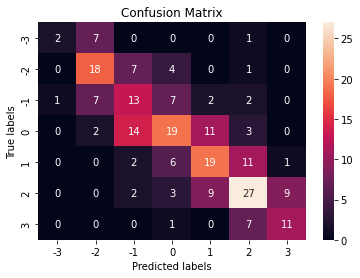

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from torch import optim

N_EPOCHS = 80

optimizer = optim.Adam(model.parameters(), lr = 2e-6, eps = 1e-8)
criterion = nn.BCELoss()

best_valid_acc = 0.0
best_valid_acc_7 = 0.0
best_valid_prec = 0.0
best_valid_f1 = 0.0
best_valid_rec = 0.0
result_report = {}
result_matrix = {}

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, train_prec, train_f1, train_rec, _ = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_acc_7, valid_prec, valid_f1, valid_rec, report, matrix = evaluate(model, valid_dataloader, criterion)

    if valid_acc >= best_valid_acc:
        result_report = report
        result_matrix = matrix
    
    best_valid_acc = max(best_valid_acc, valid_acc)
    best_valid_acc_7 = max(best_valid_acc_7, valid_acc_7)
    best_valid_prec = max(best_valid_prec, valid_prec)
    best_valid_rec = max(best_valid_rec, valid_rec)
    best_valid_f1 = max(best_valid_f1, valid_f1)


print(f"Best valid acc = {best_valid_acc}")
print(f"Best valid acc 7 = {best_valid_acc_7}")
print(f"Best valid prec = {best_valid_prec}")
print(f"Best valid f1 = {best_valid_f1}")
print(f"Best valid rec = {best_valid_rec}")
print(f'Classification report = \n {json.dumps(result_report, sort_keys=True, indent=4)}')

ax = plt.subplot()
sns.heatmap(result_matrix, annot=True, fmt='g', ax=ax);
labels = ['-3', '-2', '-1', '0', '1', '2', '3']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

100%|██████████| 20/20 [11:49<00:00, 35.47s/it]


Best valid acc = 0.4847161572052402
Best valid acc 7 = 0.4847161572052402
Best valid prec = 0.49840261209067915
Best valid f1 = 0.4819101083650754
Best valid rec = 0.4847161572052402
Classification report = 
 {
    "0.0": {
        "f1-score": 0.30769230769230765,
        "precision": 0.6666666666666666,
        "recall": 0.2,
        "support": 10
    },
    "1.0": {
        "f1-score": 0.5172413793103449,
        "precision": 0.5357142857142857,
        "recall": 0.5,
        "support": 30
    },
    "2.0": {
        "f1-score": 0.39473684210526316,
        "precision": 0.3409090909090909,
        "recall": 0.46875,
        "support": 32
    },
    "3.0": {
        "f1-score": 0.45977011494252873,
        "precision": 0.5263157894736842,
        "recall": 0.40816326530612246,
        "support": 49
    },
    "4.0": {
        "f1-score": 0.45333333333333337,
        "precision": 0.4722222222222222,
        "recall": 0.4358974358974359,
        "support": 39
    },
    "5.0": {
       

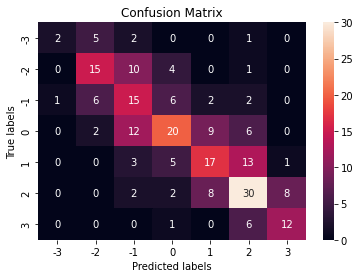

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from torch import optim

N_EPOCHS = 100

optimizer = optim.Adam(model.parameters(), lr = 2e-6, eps = 1e-8)
criterion = nn.BCELoss()

best_valid_acc = 0.0
best_valid_acc_7 = 0.0
best_valid_prec = 0.0
best_valid_f1 = 0.0
best_valid_rec = 0.0
result_report = {}
result_matrix = {}

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, train_prec, train_f1, train_rec, _ = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_acc_7, valid_prec, valid_f1, valid_rec, report, matrix = evaluate(model, valid_dataloader, criterion)

    if valid_acc >= best_valid_acc:
        result_report = report
        result_matrix = matrix
    
    best_valid_acc = max(best_valid_acc, valid_acc)
    best_valid_acc_7 = max(best_valid_acc_7, valid_acc_7)
    best_valid_prec = max(best_valid_prec, valid_prec)
    best_valid_rec = max(best_valid_rec, valid_rec)
    best_valid_f1 = max(best_valid_f1, valid_f1)


print(f"Best valid acc = {best_valid_acc}")
print(f"Best valid acc 7 = {best_valid_acc_7}")
print(f"Best valid prec = {best_valid_prec}")
print(f"Best valid f1 = {best_valid_f1}")
print(f"Best valid rec = {best_valid_rec}")
print(f'Classification report = \n {json.dumps(result_report, sort_keys=True, indent=4)}')

ax = plt.subplot()
sns.heatmap(result_matrix, annot=True, fmt='g', ax=ax);
labels = ['-3', '-2', '-1', '0', '1', '2', '3']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);